In [1]:
'''Imports'''
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
load_path = "./Cleaned Data/Historical/"

## Seasonal Soil Moisture Data

In [49]:
'''Load Data'''
soilMoist = pd.read_csv(load_path + 'MEF_seasonal_soil_moisture.csv', skiprows=1, sep=",",
                names = ["DATE", "LOCATION", "d.15", "d.46", "d.76", "d.107", "d.137", "d.168", "d.198", "d.229", "d.259", "d.290",  "d.320"],
                parse_dates = ['DATE'])
      
bulkDens = pd.read_csv(load_path + 'BulkDensity.csv', skiprows=1, sep=",",
                names = ["watershed", "LOCATION", "horizon", "horizonTop", "horizonBottom", "bulkDensity",  "H2O_1500kPa"])

In [50]:
soilMoist.head()

,DATE,LOCATION,d.15,d.46,d.76,d.107,d.137,d.168,d.198,d.229,d.259,d.290,d.320
0,1966-09-14,S1S,NaN,3.81,2.13,2.67,2.44,2.74,2.44,2.74,10.36,11.51,11.05
1,1966-09-14,S2W,NaN,3.05,2.97,2.97,2.74,2.90,3.51,3.81,3.12,1.45,2.90
2,1966-09-14,S3E,NaN,1.52,0.91,2.67,3.81,1.37,2.97,1.83,1.52,0.46,NaN
3,1966-09-14,S3W,NaN,1.37,0.91,2.51,4.11,4.27,3.20,4.88,3.43,6.25,5.79
4,1966-09-14,S4S,NaN,1.75,1.68,2.97,3.28,3.96,2.74,3.51,2.67,2.59,NaN


In [89]:
'''Data Cleaning'''
#Refine to S2 and S6 measurements
sites = ['S2E', 'S2S','S6N', 'S6S']
soilMoist_sel = soilMoist.loc[soilMoist.LOCATION.isin(sites)].reset_index()

#Reformat Data
soilMoist_melt = pd.melt(soilMoist_sel, id_vars = ['DATE', 'LOCATION'],
                        value_vars = ['d.15', 'd.46', 'd.76', 'd.107', 'd.137', 'd.168', 'd.198', 'd.229', 'd.259', 'd.290', 'd.320'])
soilMoist_melt.columns = ['DATE', 'LOCATION', 'DEPTH', 'VWC']

#Reformat depths
#soilMoist_melt['DEPTH_CM'] = [string[2:] for string in soilMoist_melt.DEPTH]

#Transform to plant available water
PAW = []
for row_index, row in soilMoist_melt.iterrows():
    #find row in bulk density frame for site and depth
    bulkTemp = bulkDens[(bulkDens.LOCATION == row.LOCATION) & (bulkDens.horizon == row.DEPTH)]

    #test if bulktemp is more than one row
    if(len(bulkTemp.LOCATION) < 1):
        PAW.append(np.NAN)
        
    else:
        #find depth of sample
        dep = float(bulkTemp.horizonBottom - bulkTemp.horizonTop)
        #print(dep)

        #multiply depth by VWC
        vol = float(row.VWC/100)*dep
        
        #subtract plant unavailable water
        plw = float(vol-(bulkTemp.H2O_1500kPa))

        #if below zero,  set to zero
        if(plw < 0):
            plw = 0

        #record
        PAW.append(plw)

soilMoist_melt['PAW'] = PAW

In [90]:
soilMoist_melt.head()

,DATE,LOCATION,DEPTH,VWC,PAW
0,1967-10-31,S2E,d.15,0.81,0.000000
1,1967-11-02,S6N,d.15,1.32,0.000000
2,1968-03-11,S2E,d.15,3.84,0.000000
3,1968-03-11,S6N,d.15,6.15,0.327260
4,1968-04-30,S2E,d.15,5.23,0.037052


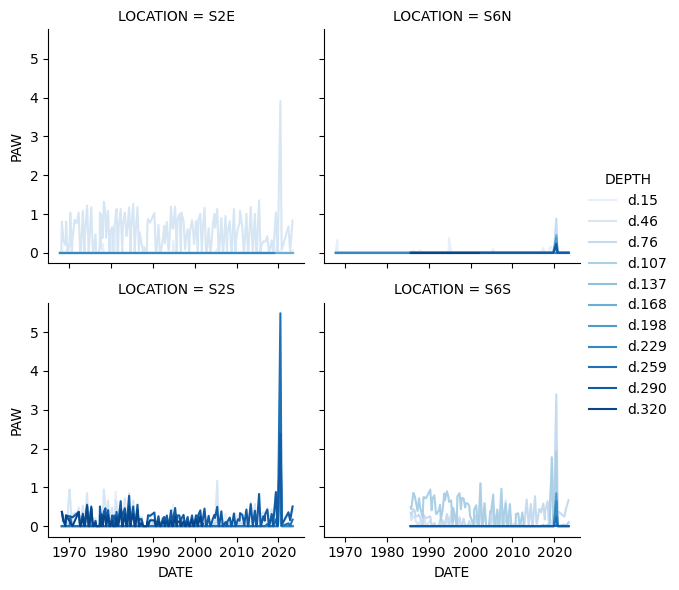

In [105]:
'''Plots'''
sns.relplot(data = soilMoist_melt, x = 'DATE', y = 'PAW',
            hue = 'DEPTH', palette = 'Blues',
            col = 'LOCATION', col_wrap = 2,
            kind = 'line', 
            height = 3)

## 10 Minute Soil Moisture Data

Snow Data to sort by seasonality

In [20]:
snowHist = pd.read_csv(load_path + 'MEF_snowSWE_biweekly.csv', 
                parse_dates = ['Date'])

#Segment out S2 data
snowHist_S2 = snowHist[snowHist.Watershed == 'S2'].reset_index(drop = True)

#Group by snow course and find max annual SWE
snowHist_S2['Year'] = snowHist_S2.Date.dt.year
snowHist_S2_grouped = snowHist_S2.groupby(['SnowcourseID', 'Year'])['SnowDEPTH', 'SWE'].max().reset_index(drop = False)

snowHist_S2_grouped.head()

C:\Users\marie\AppData\Local\Temp\ipykernel_19668\559406229.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  snowHist_S2_grouped = snowHist_S2.groupby(['SnowcourseID', 'Year'])['SnowDEPTH', 'SWE'].max().reset_index(drop = False)


,SnowcourseID,Year,SnowDEPTH,SWE
0,S21,1962,55.0,12.0
1,S21,1963,50.0,9.0
2,S21,1964,43.0,8.0
3,S21,1965,67.0,17.0
4,S21,1966,60.0,19.0


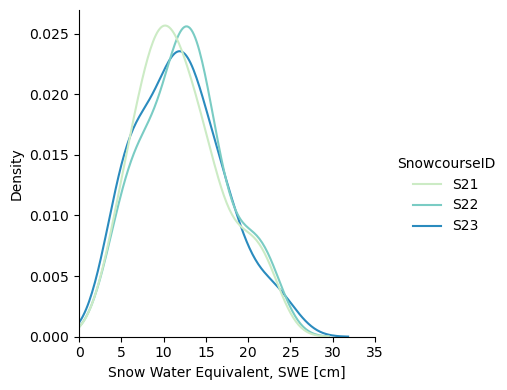

In [33]:
#S21 - South Upland, S22 - Bog, S23 - North Upland
g = sns.displot(snowHist_S2_grouped, x="SWE", hue="SnowcourseID", kind = 'kde', 
            height = 4, 
            palette = 'GnBu')
g.set(xlim = (0, 35))
g.set_axis_labels("Snow Water Equivalent, SWE [cm]", "Density")

In [38]:
#Group further by only year
snowHist_S2_grouped_all = snowHist_S2.groupby(['Year'])['SnowDEPTH', 'SWE'].max().reset_index(drop = False)

#Separate years into quantiles
snowHist_S2_grouped_all['Quants'] = pd.cut(snowHist_S2_grouped_all.SWE, 3, labels = ['LoSno', 'MedSno', 'HighSno'])
snowHist_S2_grouped_all.head()

C:\Users\marie\AppData\Local\Temp\ipykernel_19668\3586161511.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  snowHist_S2_grouped_all = snowHist_S2.groupby(['Year'])['SnowDEPTH', 'SWE'].max().reset_index(drop = False)


,Year,SnowDEPTH,SWE,Quants
0,1962,55.0,12.0,MedSno
1,1963,51.0,9.0,LoSno
2,1964,45.0,8.0,LoSno
3,1965,71.0,17.0,MedSno
4,1966,71.0,22.0,HighSno


Soil Moisture

In [45]:
soilMoist_10min = pd.read_csv(load_path + 'MEF_S2_soil_moisture_10min.csv', 
                              parse_dates = ['TIMESTAMP'])

soilMoist_10min['YEAR'] = soilMoist_10min.TIMESTAMP.dt.year
soilMoist_snow = pd.merge(soilMoist_10min, snowHist_S2_grouped_all[snowHist_S2_grouped_all.Year > 2007], left_on = 'YEAR', right_on = 'Year', how = 'outer')
soilMoist_snow = soilMoist_snow.drop('Year', axis = 1)
soilMoist_snow.head()

,TIMESTAMP,S2S_UP_SH,S2S_UP_DP,S2S_MI_SH,S2S_MI_DP,S2S_LO_SH,S2S_LO_DP,S2N_UP_SH,S2N_UP_DP,S2N_MI_SH,S2N_MI_DP,S2N_LO_SH,S2N_LO_DP,YEAR,SnowDEPTH,SWE,Quants
0,2008-11-05 14:40:00,0.22,0.42,0.23,0.57,0.21,0.24,NaN,NaN,NaN,NaN,NaN,NaN,2008,43.0,13.0,MedSno
1,2008-11-05 14:50:00,0.22,0.42,0.23,0.57,0.21,0.24,NaN,NaN,NaN,NaN,NaN,NaN,2008,43.0,13.0,MedSno
2,2008-11-05 15:00:00,0.22,0.42,0.23,0.57,0.21,0.24,NaN,NaN,NaN,NaN,NaN,NaN,2008,43.0,13.0,MedSno
3,2008-11-05 15:10:00,0.22,0.42,0.23,0.57,0.21,0.24,NaN,NaN,NaN,NaN,NaN,NaN,2008,43.0,13.0,MedSno
4,2008-11-05 15:20:00,0.22,0.42,0.23,0.57,0.21,0.24,NaN,NaN,NaN,NaN,NaN,NaN,2008,43.0,13.0,MedSno
